# Programming a binary genetic algorithm

In [1]:
import matplotlib.pyplot as plt
import seaborn, time
seaborn.set_context('talk')
seaborn.set_style('ticks')
plt.rc('font', family='serif')

In [2]:
from ipywidgets import IntProgress
from IPython.display import display, clear_output

In [3]:
import numpy as np

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Our problem:

$$
\max_{x} f(x)=x\sin\left(10\pi x\right) +1,
$$
with
$$
x\in\mathbb{R}\ \text{and}\ -1\leq x\leq 2.
$$



That is, find $x$, such that,
$$
x=\text{arg}\max\ x\sin\left(10\pi x\right) +1
$$


Let's start by taking a look at out function.

In [5]:
import math

In [6]:
def f(x):
    return x*math.sin(x*math.pi*10) +1

In [7]:
x_sample = np.linspace(-1, 2, 1000)

In [8]:
y = [f(x) for x in x_sample]

Text(0,0.5,'$f(x)$')

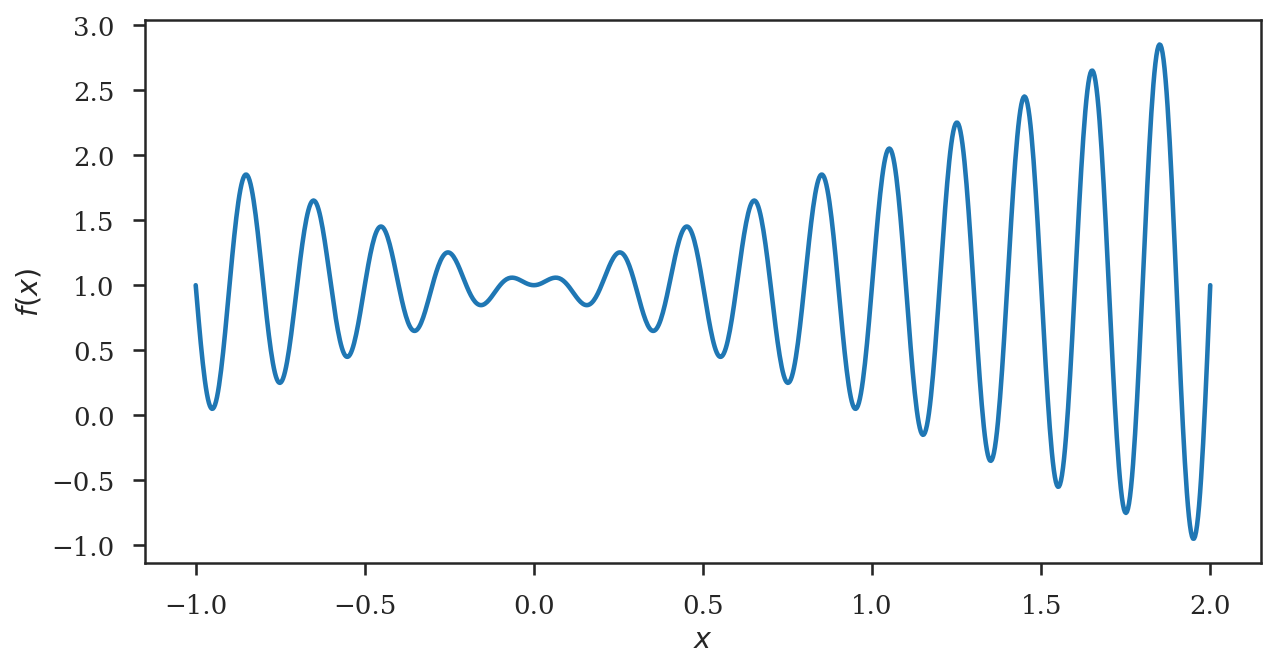

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(x_sample, y)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

We are going to rely on the DEAP Python library for coding our GA.

In [10]:
import random

from deap import base
from deap import creator
from deap import tools

We have to start by defining a new Python class that represents the fitness.

* We will use the basic DEAP fitness `deap.base.Fitness`.
* It can take multi-objective functions
* Weights decide how those objecives are scaled and if the problem is to maximize or minimize them:
$$
\min f(x)\iff\max -f(x)
$$

In [11]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

In [12]:
creator.FitnessMax

deap.creator.FitnessMax

We now define how our individuals will be. In particular, they represent the binary string a Python `list`.

In [13]:
creator.create("Individual", list, fitness=creator.FitnessMax)

In [14]:
creator.Individual

deap.creator.Individual

We also need a function that converts a binary-string individual into its real number representation.

In [15]:
def convert_binary_individual(x_bin, min_lim=-1, max_lim=2):
    # converts the list of 0's and 1's to a string
    binary_str = ''.join([str(i) for i in x_bin])
    
    # convert the binary number represented by the string to an integer
    x_int = int(binary_str, 2)
    
    # scale the integer to the valid interval
    x_float = x_int/(2**len(x_bin)-1) * (max_lim - min_lim) + min_lim
    return x_float

Consequently, for evaluating an individual we can use the following function:

In [16]:
def evaluate(ind):
    return f(convert_binary_individual(ind)), # <- remember that these functions must return an iterable

Now, we must configure the algorithm: 

* the length of our individuals,
* the cross-over probablity,
* the mutation probability, and
* the maximum number of iterations. 

In [17]:
CHROMOSOME_LENGTH = 22
CXPB = 0.1
MUTPB = 0.01
MAX_GEN = 200

DEAP uses the `Toolbox` class as a "knapsack" where we store the problem and algorithm configuration. 

In [18]:
toolbox = base.Toolbox()

# Attribute generator, only 0s and 1s
toolbox.register("attr_bool", random.randint, 0, 1)

# How do we initialize an individual?
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, CHROMOSOME_LENGTH)

# ...and the population?
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Set the individual evaluation to use the function we defined above

In [19]:
toolbox.register("evaluate", evaluate)

Use two-point crossover for mating,

In [20]:
toolbox.register("mate", tools.cxTwoPoint)

...and bit-flip mutation

In [21]:
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

Selection will use tournament of size 2.

In [22]:
toolbox.register("select", tools.selTournament, tournsize=2)

All set, we can create a new population that we will evolve.

In [23]:
pop = toolbox.population(n=50)

But let's store some statistics while we perform the optimization to see how it behaves.

In [33]:
mins, maxs, avgs, stds = [], [], [], []

In [34]:
interactive_plot = True

KeyboardInterrupt: 

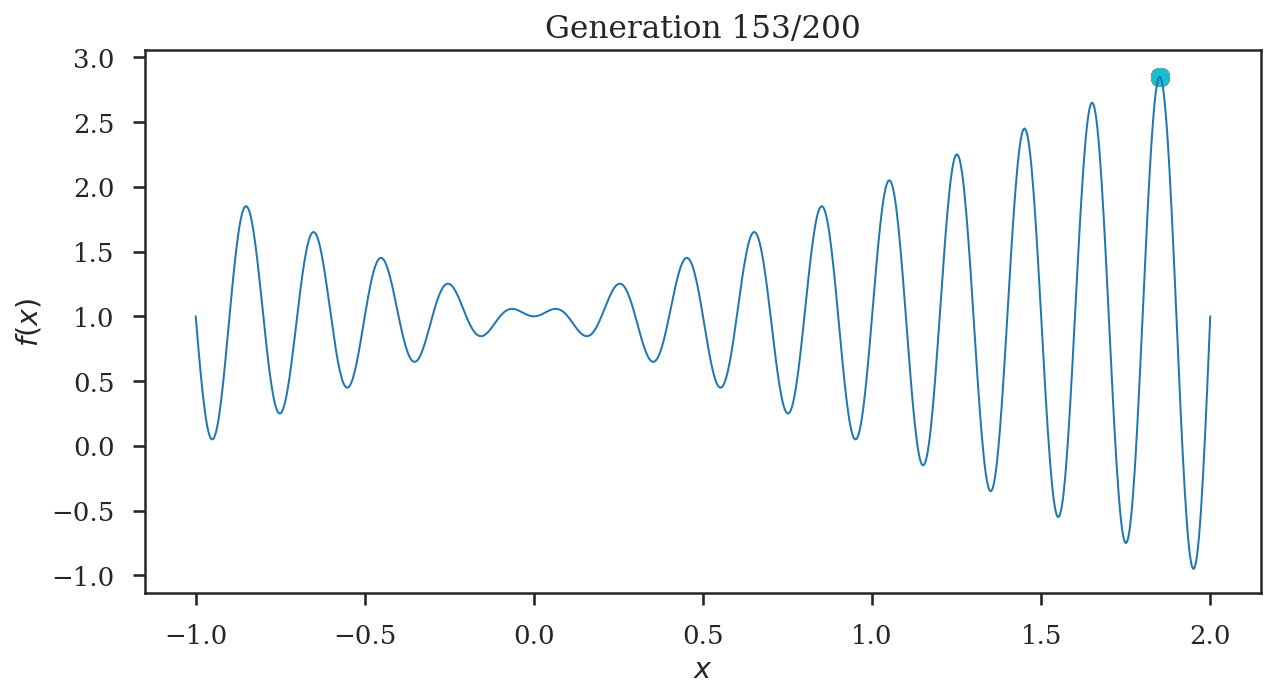

In [35]:
%%time
# prepare a figure
if interactive_plot:
    plt.figure(figsize=(10, 5))

# create a population
pop = toolbox.population(n=50)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while g < MAX_GEN:
    # A new generation
    g = g + 1

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    
    if interactive_plot:
        plt.clf()

        for ind in pop:
            plt.scatter(convert_binary_individual(ind), ind.fitness.values[0])

        plt.plot(x_sample, y, linewidth=1)
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.title('Generation {}/{}'.format(g, MAX_GEN))
        display(plt.gcf())
        clear_output(wait=True)
        # time.sleep(0.05)

    mins += [min(fits)]
    maxs += [max(fits)]
    avgs += [mean]
    stds += [std]

Text(0,0.5,'Value')

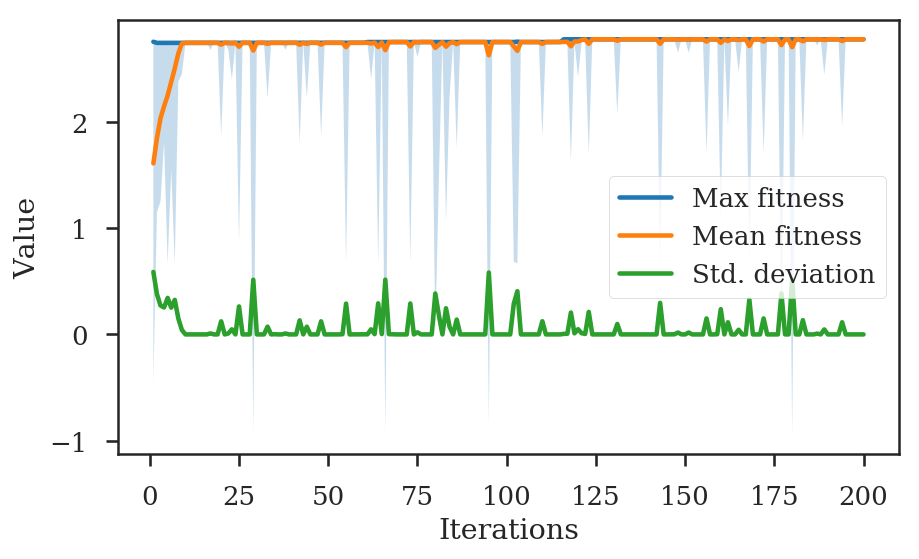

In [27]:
plt.figure(figsize=(7,4))
xx= np.arange(1,len(avgs)+1)
plt.plot(xx, maxs, label='Max fitness')
plt.plot(xx, avgs, label='Mean fitness')
plt.fill_between(xx, mins, maxs, alpha=0.25)
plt.plot(xx, stds, label='Std. deviation')
plt.legend(frameon=True)
plt.xlabel('Iterations')
plt.ylabel('Value')

## Introducing elitism

In [28]:
ELITE_SIZE = 3

In [40]:
mins_elite, maxs_elite, avgs_elite, stds_elite = [], [], [], []

In [41]:
interactive_plot = False

In [42]:
%%time
# prepare a figure
if interactive_plot:
    plt.figure(figsize=(10, 5))
    
pop = toolbox.population(n=50)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    
# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while g < MAX_GEN:
    # A new generation
    g = g + 1
    
    # Select the next generation individuals
    elite = tools.selBest(pop, ELITE_SIZE)
    
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
            # Apply crossover and mutation on the offspring

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    pop[:] = elite = tools.selBest(offspring + elite, len(pop))
    
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    mins_elite += [min(fits)]
    maxs_elite += [max(fits)]
    avgs_elite += [mean]
    stds_elite += [std]
    
    if interactive_plot:
        plt.clf()

        for ind in pop:
            plt.scatter(convert_binary_individual(ind), ind.fitness.values[0])

        plt.plot(x_sample, y, linewidth=1)
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.title('Generation {}/{}'.format(g, MAX_GEN))
        display(plt.gcf())
        clear_output(wait=True)
        # time.sleep(0.05)

CPU times: user 392 ms, sys: 4.49 ms, total: 397 ms
Wall time: 396 ms


Text(0,0.5,'Value')

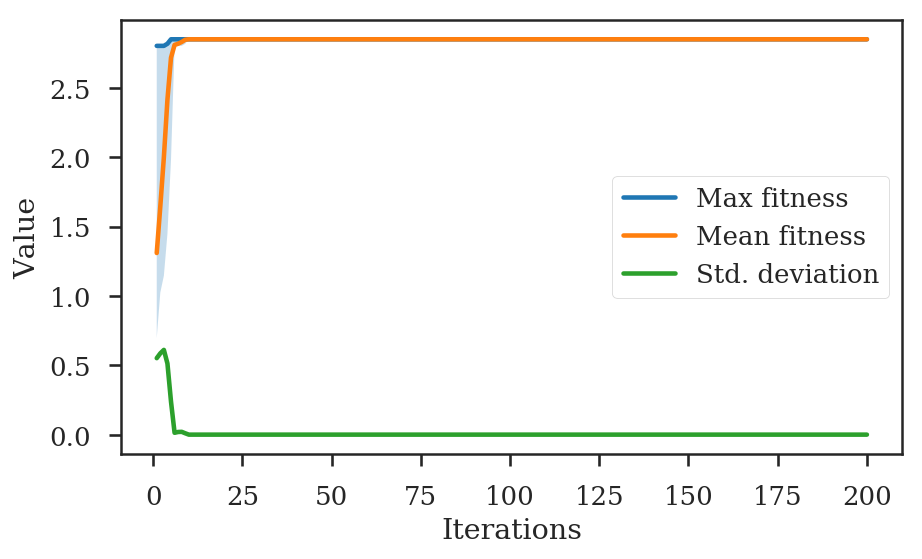

In [43]:
plt.figure(figsize=(7,4))
xx= np.arange(1,len(avgs_elite)+1)
plt.plot(xx, maxs_elite, label='Max fitness')
plt.plot(xx, avgs_elite, label='Mean fitness')
plt.fill_between(xx, mins_elite, maxs_elite, alpha=0.25)
plt.plot(xx, stds_elite, label='Std. deviation')
plt.legend(frameon=True)
plt.xlabel('Iterations')
plt.ylabel('Value')